In [109]:
# reload magic
%load_ext autoreload
%autoreload 2

In [110]:
import pickle
import os 
import numpy as np
from mindreadingautobots.sequence_generators import make_datasets, data_io

In [126]:
# Generate data with bitflip values
n_val = 10000 # number of validation examples
seed = 1234
n_data = 1000000
n_bits = 16 # number of TOTAL bits
# variables
# p_bitflips = [0, 0.05, 0.1]
# p_bitflips = [0.15]
p_bitflips = [0.2]

def hamilton_6_choose_4(n_data, n_bits, p_bitflip, seed):
    return make_datasets.k_choose_m_hamilton_forecast_dataset(k=6, m=4, n_data=n_data, n_bits=n_bits, p_bitflip=p_bitflip, seed=seed)


X, Z, idx = hamilton_6_choose_4(n_data, n_bits, p_bitflips[0], seed)

In [128]:
def xlogx(x):
    return x * np.log2(x) if x > 0 else 0

def empirical_entropy_estimate(X, intermediate_idx=[-1]):
    # n_data, n_bits = X.shape

    out = []
    lb = 0
    current_total = 0
    dct_n = {}
    dct_nminus1 = {}
    keys_n = []
    keys_nminus1 = []
    for i in intermediate_idx:
        current_bounds = [lb, i]
        keys_n_new, counts_n = np.unique(X[lb:i,:], axis=0, return_counts=True)
        keys_nminus1_new = np.unique(keys_n_new[:, :-1], axis=0)

        # keep track of the new total data
        slc_n = sum(counts_n)
        current_total += slc_n

        keys_n = list(set(keys_n + [tuple(k) for k in keys_n_new]))
        keys_nminus1 = list(set(keys_nminus1 + [tuple(k) for k in keys_nminus1_new]))

        for k, v in zip(keys_n_new, counts_n):
            if tuple(k) not in dct_n:
                dct_n[tuple(k)] = 0
            dct_n[tuple(k)] += v

            if tuple(k[:-1]) not in dct_nminus1:
                dct_nminus1[tuple(k[:-1])] = 0
            dct_nminus1[tuple(k[:-1])] += v
        
        H_Xn = 0
        for k, v in dct_n.items():
            p = v / current_total
            H_Xn -= xlogx(p)
        
        H_Xnminus1 = 0
        for k in keys_nminus1:
            p = dct_nminus1[k] / current_total
            H_Xnminus1 -= xlogx(p)
    
        out.append(H_Xn - H_Xnminus1)

        
        lb = i

    return out

In [129]:
intermediate_idx = list(range(0, n_data, 50000))
# intermediate_idx = [50, 100]
results = empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)

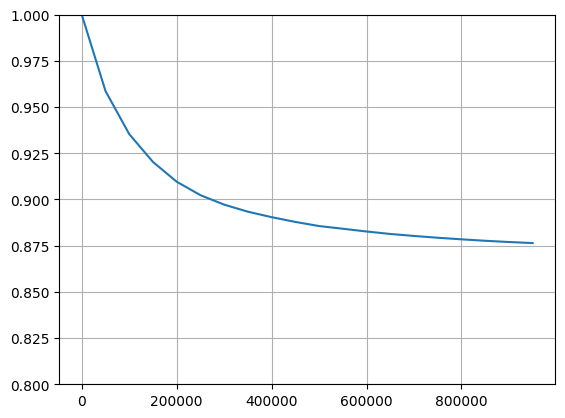

In [139]:
def h2_inverse(y):
    return 0.5 * (1 - np.sqrt(1 - y ** (4/3)))

fig, ax = plt.subplots()
ax.plot(intermediate_idx, 1 - h2_inverse(np.array(results)))
ax.set_ylim([.8, 1])
ax.grid()